# Realizando import de bibliotecas

In [172]:
# Imports and styling
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

plt.style.use('default')

# Trabalhando o dataset

Para este projeto estaremos utilizando uma base de dados presente no Kaggle denominada "Titanic - Machine Learning From Disaster". Trata-se de um dataset famoso utilizado principalmente para pessoas dando os primeiros passos dentro do mundo de Machine Learning. Vamos primeiro visualizar o dataset para saber que tipos de dados estamos tratando.

In [173]:
# Initial dataset handling
"""
survival 	Survival 	            0 = No, 1 = Yes
pclass 	    Ticket class 	        1 = 1st, 2 = 2nd, 3 = 3rd
sex 	    Sex 	
Age 	    Age in years 	
sibsp 	    # of siblings / spouses aboard the Titanic 	
parch 	    # of parents / children aboard the Titanic 	
ticket 	    Ticket number 	
fare 	    Passenger fare 	
cabin 	    Cabin number 	
embarked 	Port of Embarkation 	C = Cherbourg, Q = Queenstown, S = Southampton
"""
df_train = pd.read_csv('input/train.csv', sep=',')
df_test = pd.read_csv('input/test.csv', sep=',')
ids_test = df_test["PassengerId"]

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Ao todo temos 12 colunas, das quais 10 são parâmetros que podem ou não serem utilizados para a previsão, que são:


*   Pclass → Classe do ticket do passageiro
*   Name → Nome do passageiro
*   Sex → Gênero declarado
*   Age → Idade
*   SibSp → Número de irmãos + cônjuges no Titanic
*   Parch → Número de parentes + filhos no Titanic
*   Ticket → Número do ticket
*   Fare → Preço do ticket
*   Cabin → Cabine no Titanic
*   Embarket → Local em que embarcou (C = Cherbourg, Q = Queenstown, S = Southampton)

As outras duas restantes são as seguintes:

*   PassengerId → Número de identificação único para cada passageiro
*   Survived → Se o passageiro sobreviveu ou não (0 = Não, 1 = Sim)

O objetivo é prever a partir das características de um passageiro se o mesmo sobreviveu ou não.

## Removendo colunas e realizando mapeamento de colunas com strings

As colunas de "PassengerId", "Name", "Ticket" não são úteis para previsão, sendo únicas a cada passageiro e não fornecendo informações do ponto de vista de realizar previsões, sendo por essas razões excluídas.

In [174]:
# Remove unusuable string parameters, plus cabin has many NaN values
df_train = df_train.drop(["PassengerId", "Name", "Ticket"], axis=1)
df_test = df_test.drop(["PassengerId", "Name", "Ticket"], axis=1)

## Verificando por NaN

Como queremos apenas as entradas válidas, checamos por valores NaN.

In [175]:
df_train.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [176]:
df_test.isna().sum()

Pclass        0
Sex           0
Age          86
SibSp         0
Parch         0
Fare          1
Cabin       327
Embarked      0
dtype: int64

É possível observar casos de NaN nas colunas de "Age" e "Cabin" em ambos datasets, com alguns casos mais isolados. Devido a quantidade extremamente grande de casos NaN para a coluna "Cabin" e o fato de não vermos essa coluna como relevante para realização da previsão, optamos então por removê-la. Trabalharemos a coluna "Age" com mais detalhes.

In [177]:
# Remove unusuable string parameters, plus cabin has many NaN values
df_train = df_train.drop(["Cabin"], axis=1)
df_test = df_test.drop(["Cabin"], axis=1)

# Map strings to numeric values
df_train["Sex"] = df_train["Sex"].map({"male": 0, "female": 1})
df_train["Embarked"] = df_train["Embarked"].map({"C": 0, "Q": 1, "S": 2})
df_test["Sex"] = df_test["Sex"].map({"male": 0, "female": 1})
df_test["Embarked"] = df_test["Embarked"].map({"C": 0, "Q": 1, "S": 2})

Por fim, realizamos o mapeamento das strings das colunas de "Sex" e "Embarked" para valores inteiros, de forma a preparar as mesmas para uso pelo modelo. 

## Idade

Ao contrário da coluna de cabines, optamos por tentar manter a coluna de idade e preencher os valores NaN. Excluir as linhas que possuem NaN acarretaria uma perda de dados muito grande, e por outro lado acreditamos que idade pode representar um fator relevante na previsão do modelo, visto ser relevante na prioridade que a pessoa pode receber e nas próprias características físicas e emocionais que a pessoa pode possuir, representando características que podem ser importantes para determinar a sobrevivência de uma pessoa ou não e, por consequência, sendo ruim a exclusão da coluna. Vamos visualizar a distribuição como está presente atualmente:

<AxesSubplot:ylabel='Frequency'>

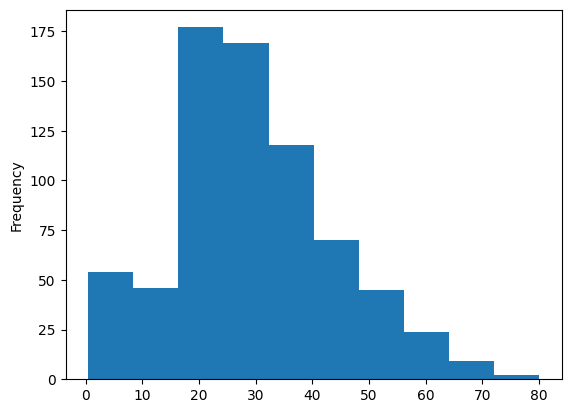

In [178]:
df_train["Age"].plot(kind='hist')

Como esperado, temos uma concentração maior de jovens adultos, com uma quantidade considerável de crianças e alguns idosos em menor quantidade.

### Preenchendo NaN's para reduzir perda de dados

Para os casos exceção visualizados anteriormente, usamos da média para colocar o valor. No caso de idade, utilizamos do IterativeImputer(), que procura prever e preencher os valores restantes. Das informações presentes, acreditamos que as características mais relacionadas com idade estão presentes em "SibSp" e "Parch".Essa suspeita é comprovada futuramente pela matriz de correlação, que pode ser visualizada logo abaixo. Além disso, durante a análise visualizamos a presença de valores negativos na idade, que foram por sua vez removidos.

In [179]:
# Fill in missing fare value
df_test["Fare"] = df_test["Fare"].replace(np.NaN, df_test["Fare"].mean())

# Fill in missing age values considering SibSp and Parch
age_cols = ["SibSp", "Parch", "Age"]
impute = IterativeImputer()

X_age = df_train[age_cols]
df_age = pd.DataFrame(np.round(impute.fit_transform(X_age)), columns=age_cols)
df_train["Age"] = df_age["Age"]

X_age = df_test[age_cols]
df_age = pd.DataFrame(np.round(impute.fit_transform(X_age)), columns=age_cols)
df_test["Age"] = df_age["Age"]

# Remove rows with negative ages
df_train["Age"] = df_train[df_train["Age"] >= 0]["Age"]

# Remove rows with empty embarked values from the training data
df_train = df_train.dropna().reset_index(drop=True)

df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,2.0
1,1,1,1,38.0,1,0,71.2833,0.0
2,1,3,1,26.0,0,0,7.9250,2.0
3,1,1,1,35.0,1,0,53.1000,2.0
4,0,3,0,35.0,0,0,8.0500,2.0


<AxesSubplot:ylabel='Frequency'>

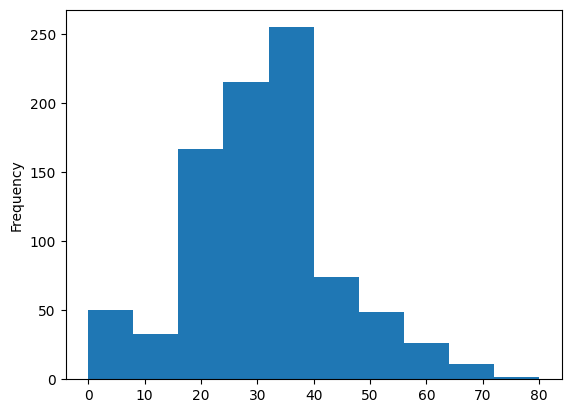

In [180]:
df_train["Age"].plot(kind='hist')

O preenchimento gera uma quantidade ainda maior de pessoas na faixa de 20 para 40 anos, o que é esperado no contexto. Experimentamos nos modelos utilizar desses valores ou optar pela simples remoção do mesmo para comparar se tal tratamento mostrou resultados ou não. Vamos visualizar a relação entre as variáveis após os tratamentos utilizados.

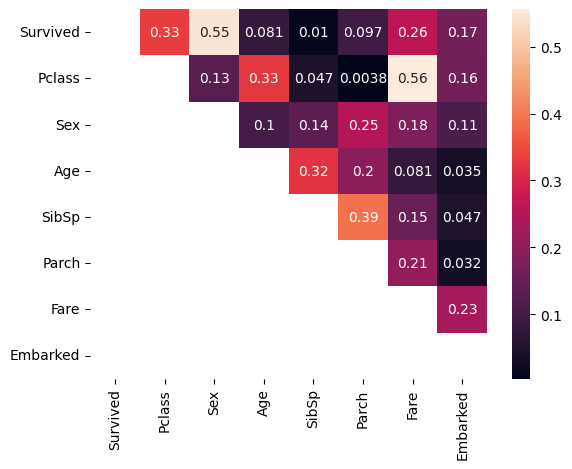

Age      0.080560
SibSp    0.010423
Parch    0.097486
Name: Survived, dtype: float64

In [181]:
# Correlation matrix to check for unusable values
corr_matrix = df_train.corr()
upper_tri = abs(corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)))
plt.figure()
sns.heatmap(upper_tri, annot=True)
plt.show()

cor_target = abs(corr_matrix["Survived"])
to_drop = cor_target[cor_target < 0.1]
to_drop

Apesar das mudanças, vemos que "Age", "SibSp" e "Parch" seguem com baixa relação com se um indivíduo sobreviveu ou não. Acreditamos que isso pode ser também relacionado com o fato das idades divergirem muito em valores mesmo com pouca mudança de características. Por essa razão, dividimos as idades de acordo com faixas etárias para melhor encaixar essas características.

* 0 - 9 anos → Crianças
* 10 - 15 anos → Adolescentes
* 16 - 24 anos → Jovens
* 25 - 59 anos → Adultos
* 60 - 80 anos → Idosos

In [182]:
bins = [-0.1, 9, 15, 24, 59, 80]
group_names = [0, 1, 2, 3, 4]

"""
child -  0 to  9 years
teen  - 10 to 15 years
young - 16 to 24 years
adult - 25 to 59 years
elder - 60 to 80 years
"""

df_train["Age"] = pd.to_numeric(pd.cut(df_train["Age"], bins, labels=group_names))

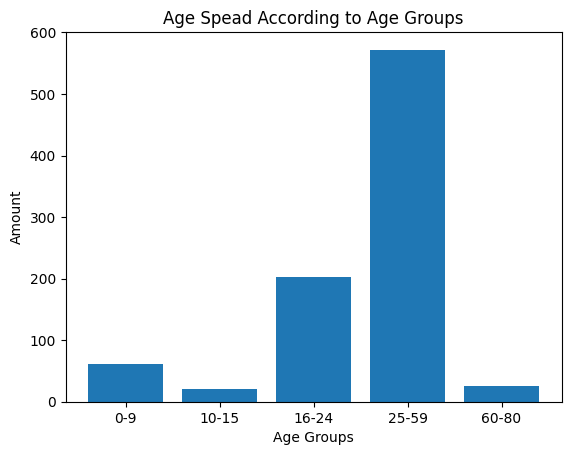

In [183]:
labels = df_train["Age"].unique()
values = df_train["Age"].value_counts().sort_index()

plt.bar(["0-9", "10-15", "16-24", "25-59", "60-80"], values)
plt.title("Age Spead According to Age Groups")
plt.xlabel("Age Groups")
plt.ylabel("Amount")
plt.show()

Conforme esperado, a quantidade de pessoas presentes na categoria de adultos é, por larga margem, a maior. Tal característica reflete o que intuitivamente seria esperado, e por essa razão optamos por manter dessa forma.

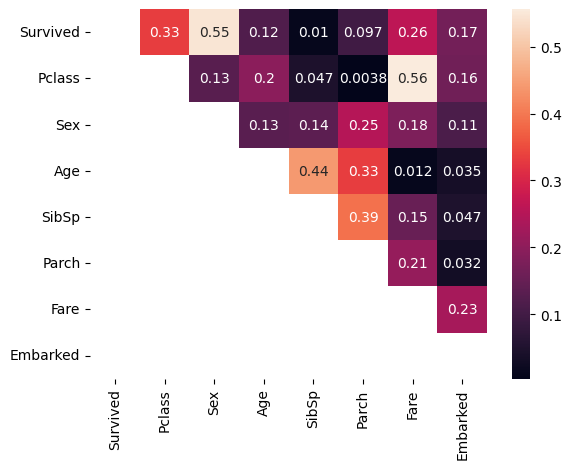

SibSp    0.010423
Parch    0.097486
Name: Survived, dtype: float64

In [184]:
# Correlation matrix to check for unusable values
corr_matrix = df_train.corr()
upper_tri = abs(corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)))
plt.figure()
sns.heatmap(upper_tri, annot=True)
plt.show()

cor_target = abs(corr_matrix["Survived"])
to_drop = cor_target[cor_target < 0.1]
to_drop

Na matriz de correlação vemos um aumento suficiente para passar a coluna idade do limiar, sendo então o suficiente para valer a tentativa de utilização. Novamente, descobriremos se tal gasto no tratamento realmente vai possuir resultados significativos. Por fim, "SibSp" e "Parch" seguem pouco relevantes e, por essa razão, são removidos.

Com todas as remoções de parâmetros feitas, fizemos a normalização dos dados.

In [185]:
# SibSp, Parch and Age have low correlation with the output parameter, so they're also removed
df_train = df_train.drop(["SibSp", "Parch"], axis=1)
df_test = df_test.drop(["SibSp", "Parch"], axis=1)

In [186]:
# Normalize data
survived_train = df_train["Survived"]

scaled_df_train = pd.DataFrame(normalize(df_train, axis=0), columns=df_train.columns)
scaled_df_test = pd.DataFrame(normalize(df_test, axis=0), columns=df_test.columns)
df_train = scaled_df_train
df_test = scaled_df_test
df_train["Survived"] = survived_train

In [187]:
X_train = df_train.drop(["Survived"], axis=1)
y_train = df_train["Survived"]

# Processo de treino

## Treinando um modelo default

Inicialmente, treinamos um modelo utilizando a função completamente "default", ou seja, com os parâmetros pré-definidos já da função.

In [188]:
dt = DecisionTreeClassifier().fit(X_train, y_train)
 
training_score = dt.score(X_train, y_train)
print("Training set score: {:.4f}".format(training_score))

Training set score: 0.9297


In [189]:
prediction = dt.predict(df_test)

In [190]:
output = pd.DataFrame({"PassengerId" : ids_test, "Survived": prediction})
output.to_csv("submission.csv", index=False)

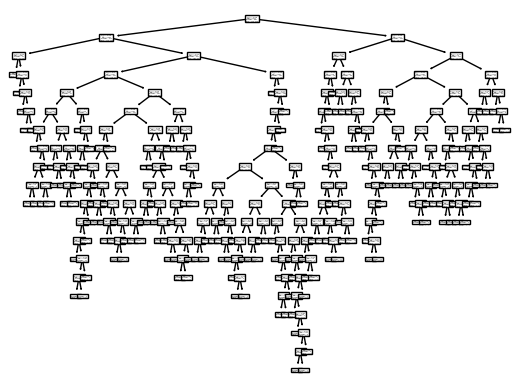

In [191]:
plot_tree(dt)
plt.show()

## Treinando um modelo simples

O valor de score nos leva a acreditar em uma possibilidade já de um processo de overfitting. Por essa razão, treinamos também um modelo mais simplificado com mudança de apenas um parâmetro.

* max_depth → Representa a profundidade máxima da árvore

In [192]:
dt = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)
 
training_score = dt.score(X_train, y_train)
print("Training set score: {:.4f}".format(training_score))

Training set score: 0.8209


In [193]:
prediction = dt.predict(df_test)

In [194]:
output = pd.DataFrame({"PassengerId" : ids_test, "Survived": prediction})
output.to_csv("submission.csv", index=False)

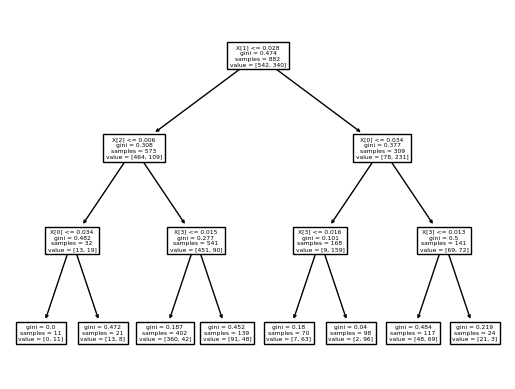

In [195]:
plot_tree(dt)
plt.show()

## Variando parâmetros

Para experimentar com os possíveis parâmetros oferecidos pela função, utilizamos da "GridSearchCV" para treinar o modelo com algumas variações de parâmetros, das quais mostramos as 5 melhores combinações. Os parâmetros em questão são, além do "max_depth" já explicado previamente:

* criterion → Função para definir a qualidade de uma divisão em certo nó
* max_feature → Número de características consideradas para determinar a divisão em um certo nó
* max_leaf_nodes → Cresce uma árvore com a quantidade passada no parâmetro utilizando best-first 

In [196]:
parameters = {'criterion':('gini', 'entropy'), 'max_depth':[2,3,4,5], 'max_features':['sqrt', 'log2'], 'max_leaf_nodes':[4,8,16,32]}
dt2 = DecisionTreeClassifier()
clf = GridSearchCV(dt2, parameters, return_train_score=True)
clf.fit(X_train, y_train)
results = pd.DataFrame(clf.cv_results_)
results.nsmallest(5, "rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
59,0.001529,0.000137,0.001123,0.000187,entropy,5,sqrt,32,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.785311,...,0.808423,0.021042,1,0.839716,0.832624,0.831445,0.849858,0.837110,0.838151,0.006574
30,0.001553,0.000329,0.001110,0.000287,gini,5,log2,16,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.762712,...,0.805059,0.026663,2,0.831206,0.787234,0.832861,0.839943,0.830028,0.824255,0.018828
53,0.001700,0.000332,0.001262,0.000440,entropy,4,log2,8,"{'criterion': 'entropy', 'max_depth': 4, 'max_...",0.819209,...,0.804995,0.019776,3,0.821277,0.805674,0.801700,0.815864,0.801700,0.809243,0.007940
49,0.001504,0.000092,0.001125,0.000274,entropy,4,sqrt,8,"{'criterion': 'entropy', 'max_depth': 4, 'max_...",0.819209,...,0.804963,0.012088,4,0.821277,0.822695,0.793201,0.815864,0.808782,0.812364,0.010756
31,0.002108,0.000829,0.001510,0.000846,gini,5,log2,32,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.802260,...,0.802729,0.030309,5,0.841135,0.851064,0.834278,0.825779,0.804533,0.831358,0.015768


## Utilizando KFold

In [197]:
cv = KFold(n_splits=10)
accuracies = list()
max_attributes = len(list(df_test))
depth_range = range(1, max_attributes + 1)

for depth in depth_range:
    fold_accuracy = []
    tree_model = DecisionTreeClassifier(max_depth=depth)
    for train_fold, valid_fold in cv.split(df_train):
        f_train = df_train.loc[train_fold]
        f_valid = df_train.loc[valid_fold]

        model = tree_model.fit(X_train, y_train)
        valid_acc = model.score(f_valid.drop(["Survived"], axis=1), f_valid["Survived"])
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy) / len(fold_accuracy)
    accuracies.append(avg)

df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.787921
         2          0.794791
         3          0.820838
         4          0.835598
         5          0.848072


# Cost Complexity Pruning

O nosso objetivo é obter estimativas confiáveis de erro a partir do conjunto de treinamento, separando uma parte dele para validação e tentando otimizar o erro nela.

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=24)

In [199]:
clf = DecisionTreeClassifier()
path = clf.cost_complexity_pruning_path(X_train, y_train)

Text(0, 0.5, 'Total impurity of leaves')

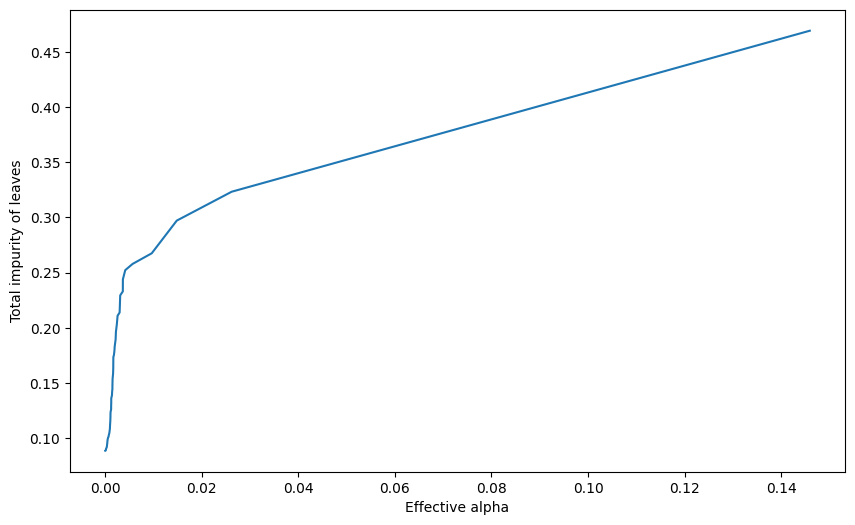

In [200]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities)
plt.xlabel("Effective alpha")
plt.ylabel("Total impurity of leaves")

In [201]:
clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

Text(0, 0.5, 'Total depth')

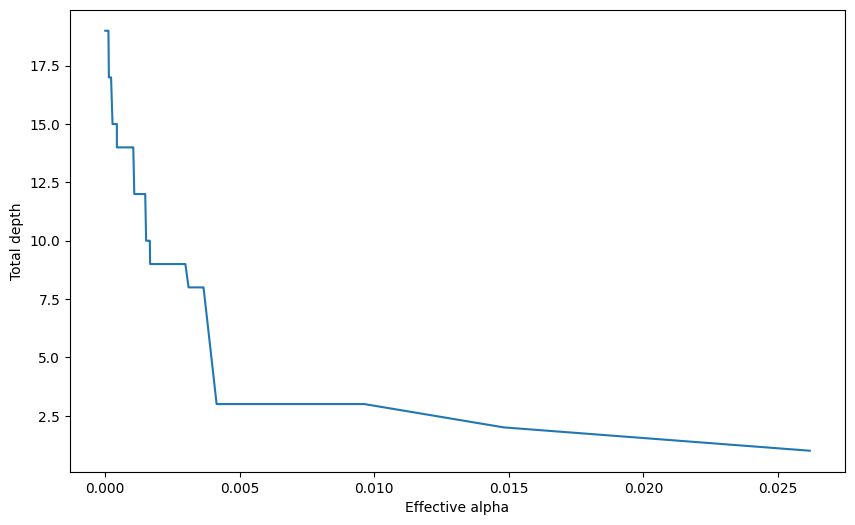

In [202]:
tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("Effective alpha")
plt.ylabel("Total depth")

Text(0, 0.5, 'Accuracy scores')

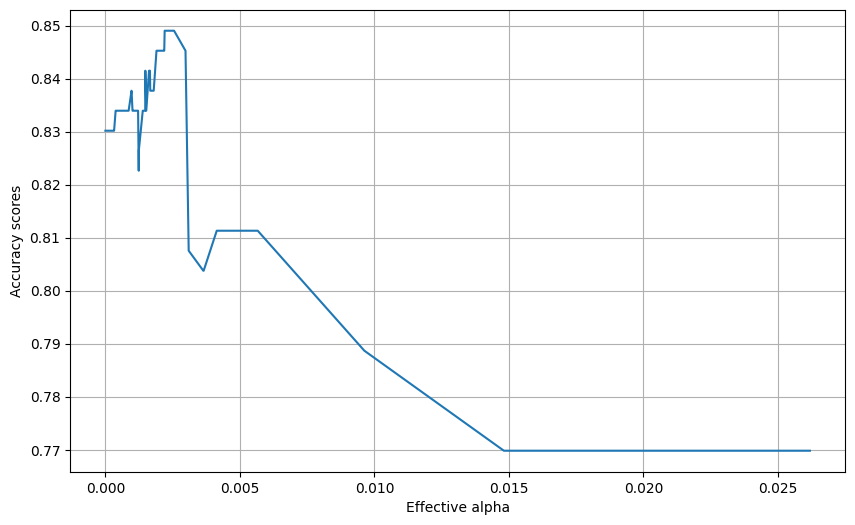

In [203]:
acc_scores = [accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("Effective alpha")
plt.ylabel("Accuracy scores")

A árvore para o valor de ccp_alpha que traz uma melhor acurácia no nosso conjunto de treinamento é:

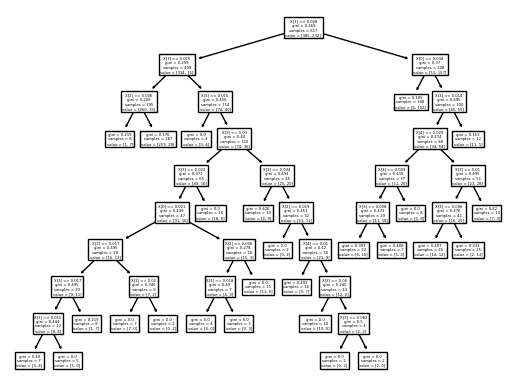

In [204]:
plot_tree(clfs[56])
plt.show()

# Visualizando os resultados no Kaggle

Previamente ao tratamento mais avançado de dados, fizemos submissões no Kaggle, variando max_depth, max_features e max_leaf_nodes. Nesse ponto do projeto, ainda não tinhamos feito tratamento em Age, e, por conta da sua baixa correlação com a variável de saída, não o estávamos considerando.

Entretanto, todas essas submissões se manteram na casa de 77%. De fato, alcancamos a pontuação de 77.99% em múltiplas submissões, mas essa foi a pontuação máxima obtida.

Após inferir os dados de Age que estavam faltando e agrupá-los em faixas etárias, fizemos mais uma série de submissões. Novamente, ficamos na faixa de 77% de acerto.

Considerando a normalização de dados e os parâmetros padrões da DecisionTreeClassifier, fizemos 3 submissões no Kaggle variando a profundidade máxima no intervalo [3, 5]:
- 3: 0.73684
- 4: 0.74641
- 5: 0.73684

Para as submissões utilizando Cost Complexity Pruning, definimos apenas o critério (gini ou entropy) e o ccp_alpha. Encontramos os melhores resultados com gini e ccp_alpha=0.03, obtendo uma pontuação de 76.315%. Com ccp_alpha=0.024, que traz o melhor resultado na partição de teste extraída do conjunto de treinamento, a pontuação é de 73.684%.